### 미들웨어 (Middleware)

#### 모든 단계에서 에이전트 실행을 제어하고 커스터마이즈하기

**미들웨어(Middleware)** 는 에이전트 내부에서 일어나는 과정을
더 세밀하게 **제어하고(customize)** 조정할 수 있는 기능을 제공합니다.

에이전트의 핵심 실행 루프(core agent loop)는 다음과 같은 과정으로 이루어집니다:

1. **모델 호출 (Call the model)** — LLM을 호출하여 다음 행동을 결정합니다.
2. **도구 실행 (Execute tools)** — 모델이 선택한 도구(tool)를 실행합니다.
3. **종료 조건 (Finish)** — 더 이상 실행할 도구가 없으면 루프를 종료합니다.

미들웨어는 이 전체 과정의 각 단계에 개입하여,
에이전트의 동작을 **감시, 수정, 또는 확장**할 수 있도록 합니다.

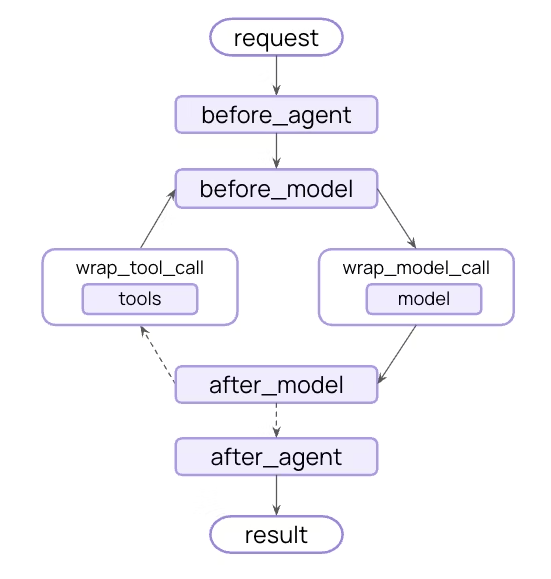

### 미들웨어 용도

- **모니터링 (Monitor)**

    * 에이전트의 동작을 **로깅(logging)**, **분석(analytics)**, **디버깅(debugging)** 을 통해 추적할 수 있습니다.
  → 예: 각 단계의 실행 시간, 선택된 도구, 에러 로그 등을 기록

- **수정 (Modify)**

    * **프롬프트(prompt)**, **도구 선택(tool selection)**, **출력 형식(output formatting)** 등을 변형하거나 조정할 수 있습니다.
  → 예: 입력 문장을 재구성하거나, 특정 도구만 사용하도록 제한

- **제어 (Control)**

    * **재시도(retries)**, **대체 실행(fallbacks)**, **조기 종료(early termination)** 로직을 추가하여
  에이전트의 실행 흐름을 제어할 수 있습니다.

- **강제 적용 (Enforce)**

    * **요율 제한(rate limits)**, **안전 가드레일(guardrails)**, **개인정보(PII) 탐지** 같은
  보안 및 정책 규칙을 적용할 수 있습니다.


In [ ]:
# model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

### 기본 제공 미들웨어 (Built-in middleware)

LangChain은 일반적인 사용 사례를 위한 **기본 제공(prebuilt) 미들웨어**를 제공합니다.

---

#### 요약 (Summarization)

대화가 **토큰 한도(token limit)** 에 가까워질 때, 대화 기록(conversation history)을 **자동으로 요약(summarize)** 해주는 기능을 수행합니다.

### 인간 개입(Human-in-the-loop)

에이전트가 도구(tool)를 실행하기 **직전 단계에서 일시 정지(pause)** 하여,
**사람이 직접 승인(approval)**, **수정(editing)**, 또는 **거부(rejection)** 할 수 있도록 하는 기능입니다.

In [ ]:
def send_email_tool(recipient: str, subject: str, body: str) -> str:
def read_email_tool(sender: str, subject: str, body: str) -> str:
                # 이메일 전송 시: 실행 전 사용자 승인/수정/거부 필요
                # 이메일 읽기 시: 자동 승인 (사용자 개입 없음)

In [ ]:
# 결제자에게 보여줄 미리보기

In [ ]:
# --- 승인(approve)
# 중단된 실행 재개 (agent.stream 사용)

---------------------------------------------------------------------
### 모델 호출 제한 (Model call limit)
모델이 무한 루프에 빠지거나 과도한 비용이 발생하지 않도록, 모델 호출 횟수를 제한할 수 있습니다.

### 도구 호출 제한 (Tool call limit)
특정 도구 또는 모든 도구에 대해 호출 횟수를 제한합니다.

### 도구 재시도 (Tool retry)
도구 호출이 실패했을 때, 자동으로 재시도하도록 설정하는 기능입니다.
이는 일시적인 네트워크 오류나 외부 API 지연 같은 문제를 완화할 때 유용합니다.

In [ ]:
# 모델 호출 횟수를 제한 설정
# Agent가 사용할 수 있는 모든 도구(tool)에 대해 전역적으로 호출 횟수를 제한
# 특정 도구(search)에 대한 개별 호출 제한 설정

### PII 감지 (PII Detection)
대화 중에 개인 식별 정보(PII, Personally Identifiable Information) 가 포함되어 있는지를 탐지하고 처리합니다. 
- 이름, 주민등록번호, 여권번호
- 이메일 주소, 전화번호
- 집 주소, IP 주소
- 신용카드 번호 등

| 전략 이름 (`strategy`) | 동작 방식                                         | 예시                                                  | 사용 목적                        |
| ------------------ | --------------------------------------------- | --------------------------------------------------- | ---------------------------- |
| `"redact"`         | **완전히 가리기** — 탐지된 부분을 `[REDACTED]`로 대체        | `"내 이메일은 test@example.com"` → `"내 이메일은 [REDACTED]"` | 입력/출력에서 개인정보를 완전히 숨기고 싶을 때   |
| `"mask"`           | **일부만 표시** — 대부분을 `*`로 가리고 일부(예: 마지막 4자리)만 유지 | `"1234-5678-9012-3456"` → `"****-****-****-3456"`   | 신용카드·전화번호처럼 일부만 보여도 되는 경우    |
| `"hash"`           | **해시 처리** — 감지된 값을 해시(예: SHA256)로 변환          | `"test@example.com"` → `"4f7d3a7a9c..."`            | 원문을 숨기되, 같은 입력값을 구분·추적해야 할 때 |
| `"block"`          | **차단** — 탐지 시 예외 발생 (`PIIDetectionError`)     | `"sk-abc..."` → ❌ 실행 중단                             | API Key 등 절대 노출되어선 안 되는 경우   |
| `"remove"`         | **제거** — 감지된 부분을 빈 문자열로 완전히 삭제                | `"내 전화번호는 010-1234-5678"` → `"내 전화번호는 "`            | 문맥 유지 없이 완전히 삭제할 때           |
| `"log"`            | **탐지 로그만 남기고 원문 유지**                          | `"test@example.com"` → 그대로 유지, 내부 로그만 기록            | 개발·테스트 중 PII 탐지 여부를 점검할 때    |


In [ ]:
        # 사용자 입력에서 이메일 주소를 탐지하고 가리기 (redact)
        # 예: "my email is test@example.com" → "my email is [REDACTED]"
        # 신용카드 번호를 마스킹 처리 (마지막 4자리만 표시)
        # 예: "1234-5678-9012-3456" → "****-****-****-3456"
        # 사용자 정의 PII 유형 추가 (정규식 기반)
        # 예: API 키 형식 "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
        # 감지 시 실행 중단 (block)